# LDA (Latent Dirichlet Allocation) & LSI (Latent Semantic Indexing)

#### Set parameters for how final model results will be saved

In [1]:
tokenized_run_name = "weighted_1_tokens"  #manually input the filename (no extension) to be used as input

In [2]:
data_directory = "../data/"
output_directory = "../outputs/"

In [3]:
base_model_type = "lda_lsi"
model_name_suffix = ""  #default should be blank; use to make note of any other mods
run_number = 2

In [4]:
final_model_name = f"{base_model_type}_{tokenized_run_name[:-7]}_run{run_number}{model_name_suffix}"

#### Imports

In [5]:
# general use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # for LDA modeling & presentation
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# # for LSA modeling
from sklearn.decomposition import TruncatedSVD

# for progress bar on loops
from tqdm import tqdm

#### Read in Dataframe with tokenized text

In [6]:
df = pd.read_csv(f"{data_directory}{tokenized_run_name}.csv")
df.head()

,name,href,tokenized_text
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...


In [7]:
df.isna().sum()

name              0
href              0
tokenized_text    0
dtype: int64

In [8]:
df.fillna("",inplace=True)

#### Count Vectorization & TfIDF

In [9]:
# Function draws heavily from Jiamei Wang's code: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def make_tfidf(input_df, text_colname='tokenized_text'):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        
    OUTPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    docs_raw = input_df[text_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    cvec = CountVectorizer(strip_accents = 'unicode',
                            stop_words = 'english',
                            lowercase = True,
                            token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                            max_df = 0.5,                        # discard words that appear in > 50% of the reviews
                            min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**cvec.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} non-unique words in {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], text_colname, dtm_tfidf.shape[1]))
    
    # return tf_vectorizer, tfidf_vectorizer, dtm_tfidf
    return tfidf_vectorizer, dtm_tfidf

In [10]:
tfidf_vectorizer, dtm_tfidf = make_tfidf(df, 'tokenized_text')

d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


The shape of the tfidf is (2484, 16937), meaning that there are 2484 non-unique words in tokenized_text and 16937 tokens made through the filtering process.


#### Grid Search for best LDA model

In [11]:
# Define Grid Search Parameters
search_params = {'n_components': [5, 10, 20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

In [12]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_gridsearch(dtm_tfidf, search_params):
    '''
    INPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        model_gs - the GridSearchCV object
        best_lda_model - the best model, as determined by the grid search
    '''

    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model_gs = GridSearchCV(lda, param_grid=search_params, n_jobs=8, verbose=3)

    # Do the Grid Search
    model_gs.fit(dtm_tfidf)

    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model_gs.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model_gs.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model_gs.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))

    return model_gs, best_lda_model

In [13]:
model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Model Log Likelihood Score:  -44026.22009143875
Model Perplexity:  24045.947671849368


#### Plotting LDA model performance

In [14]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_plot_performance(model_gs, search_params):
    ''' 
    INPUTS:
        model_gs - the GridSearchCV object
        
    OUTPUTS:
        A graph comparing LDA Model Performance Scores with different params
    '''

    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelihoods from Grid Search Output
    gscore=model_gs.cv_results_

    log_likelihoods = {}
    for i in search_params['learning_decay']:
        log_likelihoods[i] = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==i]

    # Show graph
    plt.figure(figsize=(12, 8))
    for i in log_likelihoods:
        plt.plot(search_params['n_components'], log_likelihoods[i], label=i)
 
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelihood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return

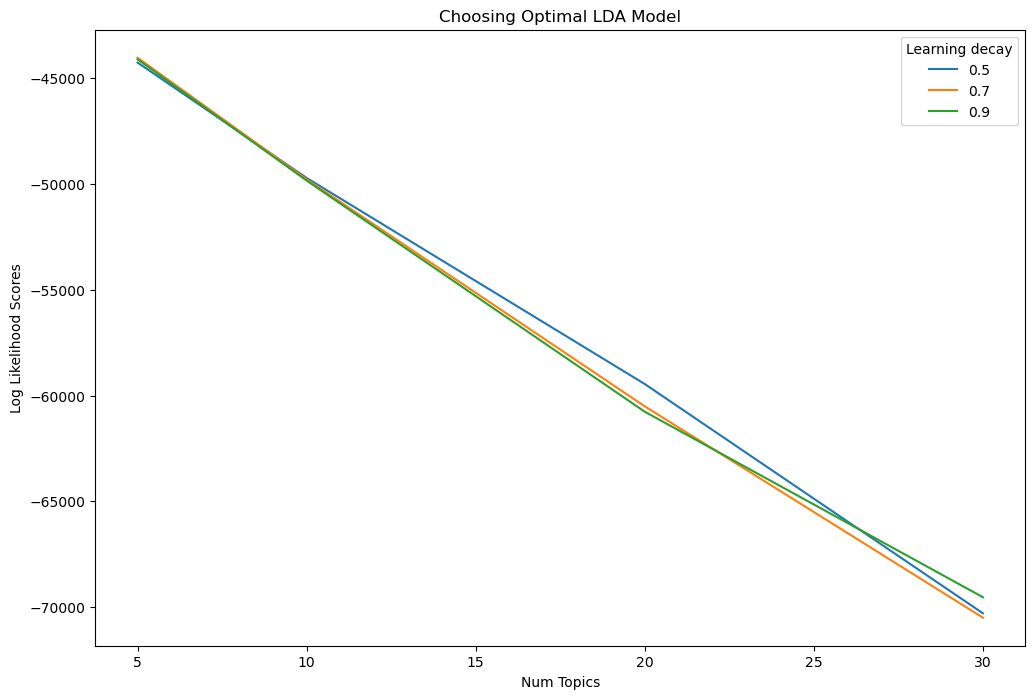

In [15]:
lda_plot_performance(model_gs, search_params)

#### (optional) Combined function for creating "best" LDA model with performance plot

In [16]:
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for more convenient parameter tuning)
# Once tuned/optimized, all 3 sub-functions can be run together in one command, wholly recreating the method used in the source referenced above

def optimal_lda_model(input_df, text_colname, search_params):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        best_lda_model - the best model, as determined by the grid search
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    
    tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
    model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)
    lda_plot_performance(model_gs, search_params)

    return best_lda_model, dtm_tfidf, tfidf_vectorizer

In [17]:
# (Same as above, in one single function call)

# best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df, 'combined_text', search_params)

#### Display topic keywords & weights

In [18]:
# Function excerpted directly with no additional modifications from: (Jiamei Wang)
# https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08

#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in tqdm(enumerate(model.components_)):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


In [19]:
lda_topic_words = display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words.head(10)

5it [00:00, 475.61it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,mysticism,0.2,anime,57.1,comedy,180.3,mysticism,0.2,genetics,1.5
1,furry,0.2,manga,33.9,crime,134.5,furry,0.2,cuisine,1.1
2,dusk,0.2,animation,28.5,romance,96.4,dusk,0.2,culinary,1.0
3,standoff,0.2,action,24.7,animation,91.9,standoff,0.2,zeitgeist,0.7
4,valhalla,0.2,adventure,20.9,adventure,84.4,valhalla,0.2,dining,0.6
5,hideout,0.2,space,18.0,mystery,83.8,hideout,0.2,cooking,0.3
6,brutus,0.2,shounen,16.9,action,79.8,brutus,0.2,chef,0.2
7,vigilantism,0.2,superhero,14.2,fantasy,67.8,vigilantism,0.2,flux,0.2
8,mushroom,0.2,apocalyptic,12.9,thriller,60.9,mushroom,0.2,fine,0.2
9,tulsa,0.2,seinen,10.2,novel,59.3,tulsa,0.2,regenerative,0.2


#### Visualizing LDA output with the pyLDAvis library

In [20]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.110571 -0.005083       1        1  86.097230
1     -0.039638 -0.042659       2        1   6.800984
4     -0.023746  0.016091       3        1   2.377357
0     -0.023593  0.015826       4        1   2.362214
3     -0.023593  0.015826       5        1   2.362214, topic_info=            Term       Freq      Total Category  logprob  loglift
635    animation  78.000000  78.000000  Default  30.0000  30.0000
141       action  68.000000  68.000000  Default  29.0000  29.0000
248    adventure  70.000000  70.000000  Default  28.0000  28.0000
641        anime  15.000000  15.000000  Default  27.0000  27.0000
14800  superhero  20.000000  20.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
7188       horde   0.025430   0.480060   Topic5  -9.7367   0.8076
9207        maki   0.025430   0.377282   Topic5  -9.7367   1.0485
3779    darkwing   0.025429   0.694255   Topic5  -9.7367   0.4386
10723      opium   0.025429   0.684203   Topic5  -9.7367   0.4532
2736    claudius   0.025429   0.406137   Topic5  -9.7367   0.9748

[317 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
141        1  0.909220     action
141        2  0.102654     action
236        1  1.010737      adult
248        1  0.919263  adventure
248        2  0.084855  adventure
...      ...       ...        ...
16248      2  0.769069     viking
16405      1  0.957099        war
16405      2  0.045576        war
16825      2  1.017715     yakuza
16865      1  0.977634       york

[159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

#### Generate results (fit-transorm) from a LDA model and tfidf matrix

In [21]:
lda_results = best_lda_model.fit_transform(dtm_tfidf) 

#### Append the LDA topic % matches onto the results dataframe

In [22]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lda_topic_pct_cols(lda_results, df_to_append_to, name_prefix=""):
    
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lda_results[j]):
            df_to_append_to.loc[j, f"{name_prefix}lda_topic{i}_match_pct"] = topic
    return
        

In [23]:
make_lda_topic_pct_cols(lda_results, df)

100%|██████████| 2484/2484 [00:00<00:00, 3873.60it/s]


In [24]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.009928,0.009928,0.960288,0.009928,0.009928
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.017903,0.017903,0.928387,0.017903,0.017903
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.025177,0.025177,0.899292,0.025177,0.025177
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.015854,0.015854,0.936583,0.015854,0.015854
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.018286,0.018286,0.926856,0.018286,0.018286


In [25]:
df.shape

(2484, 8)

# LSA model

In [26]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/


# Define the number of topics or components
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_results = lsa.fit_transform(dtm_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

In [27]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/

# Print the topics with their terms

def lsa_topics_out(tfidf_vectorizer, svd_object):
    terms = tfidf_vectorizer.get_feature_names_out()

    for index, component in enumerate(svd_object.components_):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        print("Topic "+str(index)+": ",top_terms_list)

    return

In [28]:
lsa_topics_out(tfidf_vectorizer, lsa)

Topic 0:  ['comedy', 'animation', 'crime', 'adventure', 'action', 'romance', 'mystery', 'anime', 'fantasy', 'novel']
Topic 1:  ['crime', 'mystery', 'murder', 'investigation', 'thriller', 'detective', 'police', 'documentary', 'biography', 'miniseries']
Topic 2:  ['comedy', 'romance', 'sitcom', 'friendship', 'workplace', 'lgbt', 'teen', 'school', 'relationship', 'satire']
Topic 3:  ['horror', 'fantasy', 'romance', 'novel', 'book', 'supernatural', 'mystery', 'anthology', 'vampire', 'sci']
Topic 4:  ['romance', 'anime', 'manga', 'shounen', 'school', 'novel', 'crime', 'biography', 'seinen', 'slice']
Topic 5:  ['documentary', 'biography', 'miniseries', 'adventure', 'history', 'action', 'war', 'superhero', 'alien', 'historical']
Topic 6:  ['documentary', 'anime', 'biography', 'horror', 'fantasy', 'manga', 'animation', 'supernatural', 'miniseries', 'anthology']
Topic 7:  ['thriller', 'documentary', 'anime', 'psychological', 'sci', 'manga', 'horror', 'comedy', 'conspiracy', 'sport']
Topic 8:  [

In [29]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lsa_topic_pct_cols(lsa_results, df_to_append_to):
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lsa_results[j]):
            df_to_append_to.loc[j, f"lsa_topic{i}_cos_match"] = topic
    return

In [30]:
make_lsa_topic_pct_cols(lsa_results, df)

100%|██████████| 2484/2484 [00:01<00:00, 1999.23it/s]


In [31]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct,lsa_topic0_cos_match,lsa_topic1_cos_match,lsa_topic2_cos_match,lsa_topic3_cos_match,lsa_topic4_cos_match,lsa_topic5_cos_match,lsa_topic6_cos_match,lsa_topic7_cos_match,lsa_topic8_cos_match,lsa_topic9_cos_match
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.009928,0.009928,0.960288,0.009928,0.009928,0.268433,-0.020426,-0.090606,0.210743,-0.063944,0.141392,-0.023703,-0.087125,-0.060328,-0.034420
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.017903,0.017903,0.928387,0.017903,0.017903,0.137642,0.094227,-0.045861,-0.034546,0.009111,0.031247,-0.046990,0.009384,-0.067450,-0.029514
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.025177,0.025177,0.899292,0.025177,0.025177,0.118722,-0.028396,-0.080808,0.027768,0.016996,0.127396,-0.056874,-0.040274,-0.029825,-0.022236
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.015854,0.015854,0.936583,0.015854,0.015854,0.295292,0.046381,-0.039057,-0.106146,-0.076353,0.074971,-0.130190,-0.068372,-0.248528,0.035764
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.018286,0.018286,0.926856,0.018286,0.018286,0.149727,-0.046886,-0.102071,0.059495,-0.065898,0.123360,-0.100009,-0.042234,0.005015,-0.119780


In [32]:
df.shape

(2484, 18)

## Force LDA evaluate with different parameters

#### Generate same output items for forced alternate (20+ topic) model

In [33]:
# Define Grid Search Parameters
search_params2 = {'n_components': [20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 20}
Model Log Likelihood Score:  -59804.22611211679
Model Perplexity:  75292.33828470572


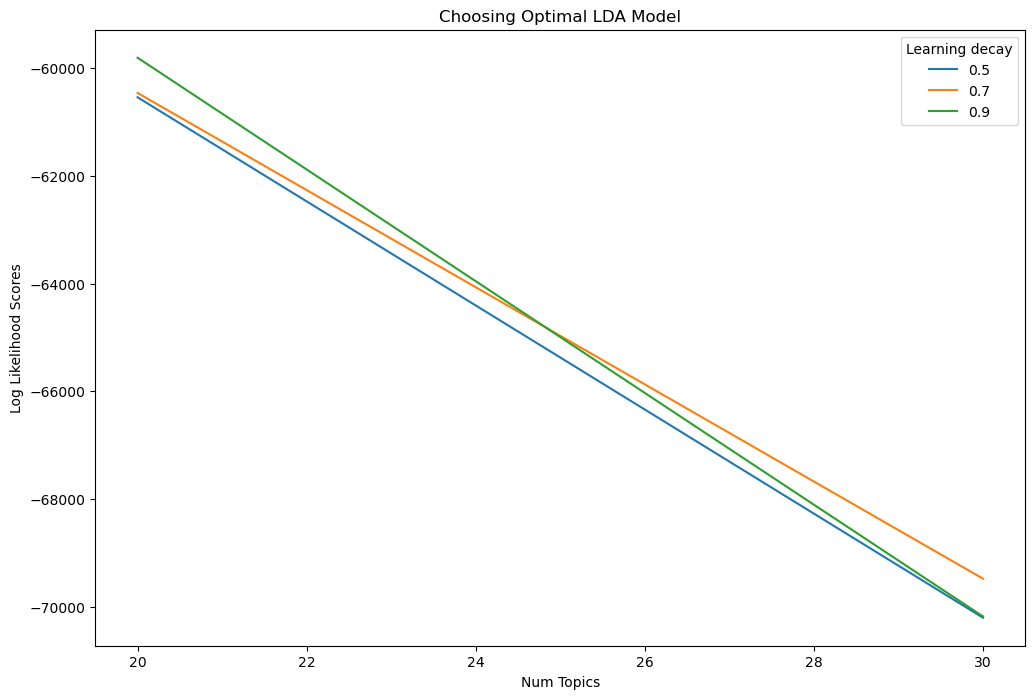

In [34]:
# tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
model_gs2, best_lda_model2 = lda_gridsearch(dtm_tfidf, search_params2)
lda_plot_performance(model_gs2, search_params2)

In [35]:
lda_topic_words2 = display_topics(best_lda_model2, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words2.head()

20it [00:00, 654.63it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,...,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights,Topic 20 words,Topic 20 weights
0,sas,1.4,paramedic,2.2,extramarital,2.6,parenthood,3.5,islam,0.7,...,startup,1.7,anime,54.9,trek,3.4,bionic,2.4,mermaid,2.5
1,autism,1.0,wormhole,2.1,hologram,2.1,psychotherapist,1.7,approved,0.5,...,skating,1.3,manga,33.7,simpler,3.1,catholicism,2.3,sonic,2.0
2,aging,0.7,mushroom,0.9,downstairs,1.5,ncis,1.7,gianni,0.4,...,impostor,1.2,shounen,16.7,hawaii,2.2,ottoman,2.2,scooby,1.8
3,crab,0.7,grandparent,0.8,mossad,1.5,utopia,1.6,ramsay,0.4,...,autobiographical,0.8,martial,12.0,cyberpunk,2.2,exorcism,2.0,doo,1.8
4,dome,0.7,manufacturing,0.8,innuendo,1.4,hercules,1.2,nightmares,0.3,...,continents,0.5,seinen,10.1,starship,2.0,environmentalism,1.5,amnesia,1.7


In [36]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model2, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.181478  0.045166       1        1  83.916790
16     0.128482  0.067107       2        1   4.068150
17     0.005478 -0.016036       3        1   0.757978
11     0.004392 -0.014082       4        1   0.743871
5      0.004330 -0.015391       5        1   0.732167
18     0.003565 -0.008487       6        1   0.691894
14     0.003808 -0.007933       7        1   0.689986
6      0.003447 -0.008122       8        1   0.687213
12     0.003010 -0.008800       9        1   0.679177
9      0.002904 -0.007719      10        1   0.677973
19     0.003895 -0.004825      11        1   0.675931
2      0.003023 -0.006650      12        1   0.672720
3      0.002340 -0.005180      13        1   0.653079
13     0.002512 -0.003271      14        1   0.644393
1      0.002373 -0.002385      15        1   0.638218
15     0.001697 -0.002502      16        1   0.625210
7      0.001891 -0.001467      17        1   0.623430
0      0.001721 -0.001115      18        1   0.617242
8      0.001412  0.000215      19        1   0.607463
4      0.001198  0.001478      20        1   0.597117, topic_info=               Term        Freq       Total Category  logprob  loglift
641           anime   27.000000   27.000000  Default  30.0000  30.0000
9254          manga   15.000000   15.000000  Default  29.0000  29.0000
635       animation  100.000000  100.000000  Default  28.0000  28.0000
9384         marvel    6.000000    6.000000  Default  27.0000  27.0000
13836       shounen    7.000000    7.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
9420   masturbation    0.006408    0.298223  Topic20  -9.7398   1.2805
10570     obscenity    0.006408    0.303933  Topic20  -9.7398   1.2615
648           ankle    0.006408    0.332749  Topic20  -9.7398   1.1710
12398      redirect    0.006408    0.310129  Topic20  -9.7398   1.2414
2310     casablanca    0.006408    0.317314  Topic20  -9.7398   1.2184

[795 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
141        1  0.992681     action
222        1  0.638333   adoption
248        1  0.996598  adventure
315        1  0.990156      agent
348        1  1.056678       aids
...      ...       ...        ...
16405      1  1.009549        war
16491      2  0.908948   webcomic
16498      2  0.783051    webtoon
16545      1  1.025069   werewolf
16626      1  0.602676   wildlife

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 17, 18, 12, 6, 19, 15, 7, 13, 10, 20, 3, 4, 14, 2, 16, 8, 1, 9, 5])

In [37]:
lda_results2 = best_lda_model2.fit_transform(dtm_tfidf) 

In [38]:
make_lda_topic_pct_cols(lda_results2, df, "forced_alt_")

100%|██████████| 2484/2484 [00:02<00:00, 1066.21it/s]


## Save final results dataframe

> Saves only the results columns.  All other columns can be obtained from prior dataframes

In [39]:
df.columns

Index(['name', 'href', 'tokenized_text', 'lda_topic0_match_pct',
       'lda_topic1_match_pct', 'lda_topic2_match_pct', 'lda_topic3_match_pct',
       'lda_topic4_match_pct', 'lsa_topic0_cos_match', 'lsa_topic1_cos_match',
       'lsa_topic2_cos_match', 'lsa_topic3_cos_match', 'lsa_topic4_cos_match',
       'lsa_topic5_cos_match', 'lsa_topic6_cos_match', 'lsa_topic7_cos_match',
       'lsa_topic8_cos_match', 'lsa_topic9_cos_match',
       'forced_alt_lda_topic0_match_pct', 'forced_alt_lda_topic1_match_pct',
       'forced_alt_lda_topic2_match_pct', 'forced_alt_lda_topic3_match_pct',
       'forced_alt_lda_topic4_match_pct', 'forced_alt_lda_topic5_match_pct',
       'forced_alt_lda_topic6_match_pct', 'forced_alt_lda_topic7_match_pct',
       'forced_alt_lda_topic8_match_pct', 'forced_alt_lda_topic9_match_pct',
       'forced_alt_lda_topic10_match_pct', 'forced_alt_lda_topic11_match_pct',
       'forced_alt_lda_topic12_match_pct', 'forced_alt_lda_topic13_match_pct',
       'forced_alt_ld

In [40]:
# (default) if reading from a tokenized-only df
columns_to_drop = ['tokenized_text']

# for cases run using other (non-standard) df's as input
#columns_to_drop = ['combined_text', 'lemmatized_text', 'tokenized_text']

In [41]:
df.drop(columns=columns_to_drop, inplace=True)

In [42]:
df.to_csv(f"{output_directory}{final_model_name}.csv", index=False)
# df.to_json(f"{output_directory}{final_model_name}.json")

#### Save topic words matrices

In [43]:
lda_topic_words.to_csv(f"{output_directory}{final_model_name}_topicwords.csv", index=False)

In [44]:
lda_topic_words2.to_csv(f"{output_directory}{final_model_name}_topicwords_forced_alt.csv", index=False)